In [1]:
import scanpy as sc
import drug2cell as d2c
import blitzgsea as blitz
import pandas as pd

In [3]:
sc.settings.set_figure_params(dpi=800)

In [5]:
adata = sc.read_h5ad('Tcell_data.h5ad')

/public/home/n_w/.conda/envs/bcells/lib/python3.6/site-packages/anndata/compat/__init__.py:183: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,


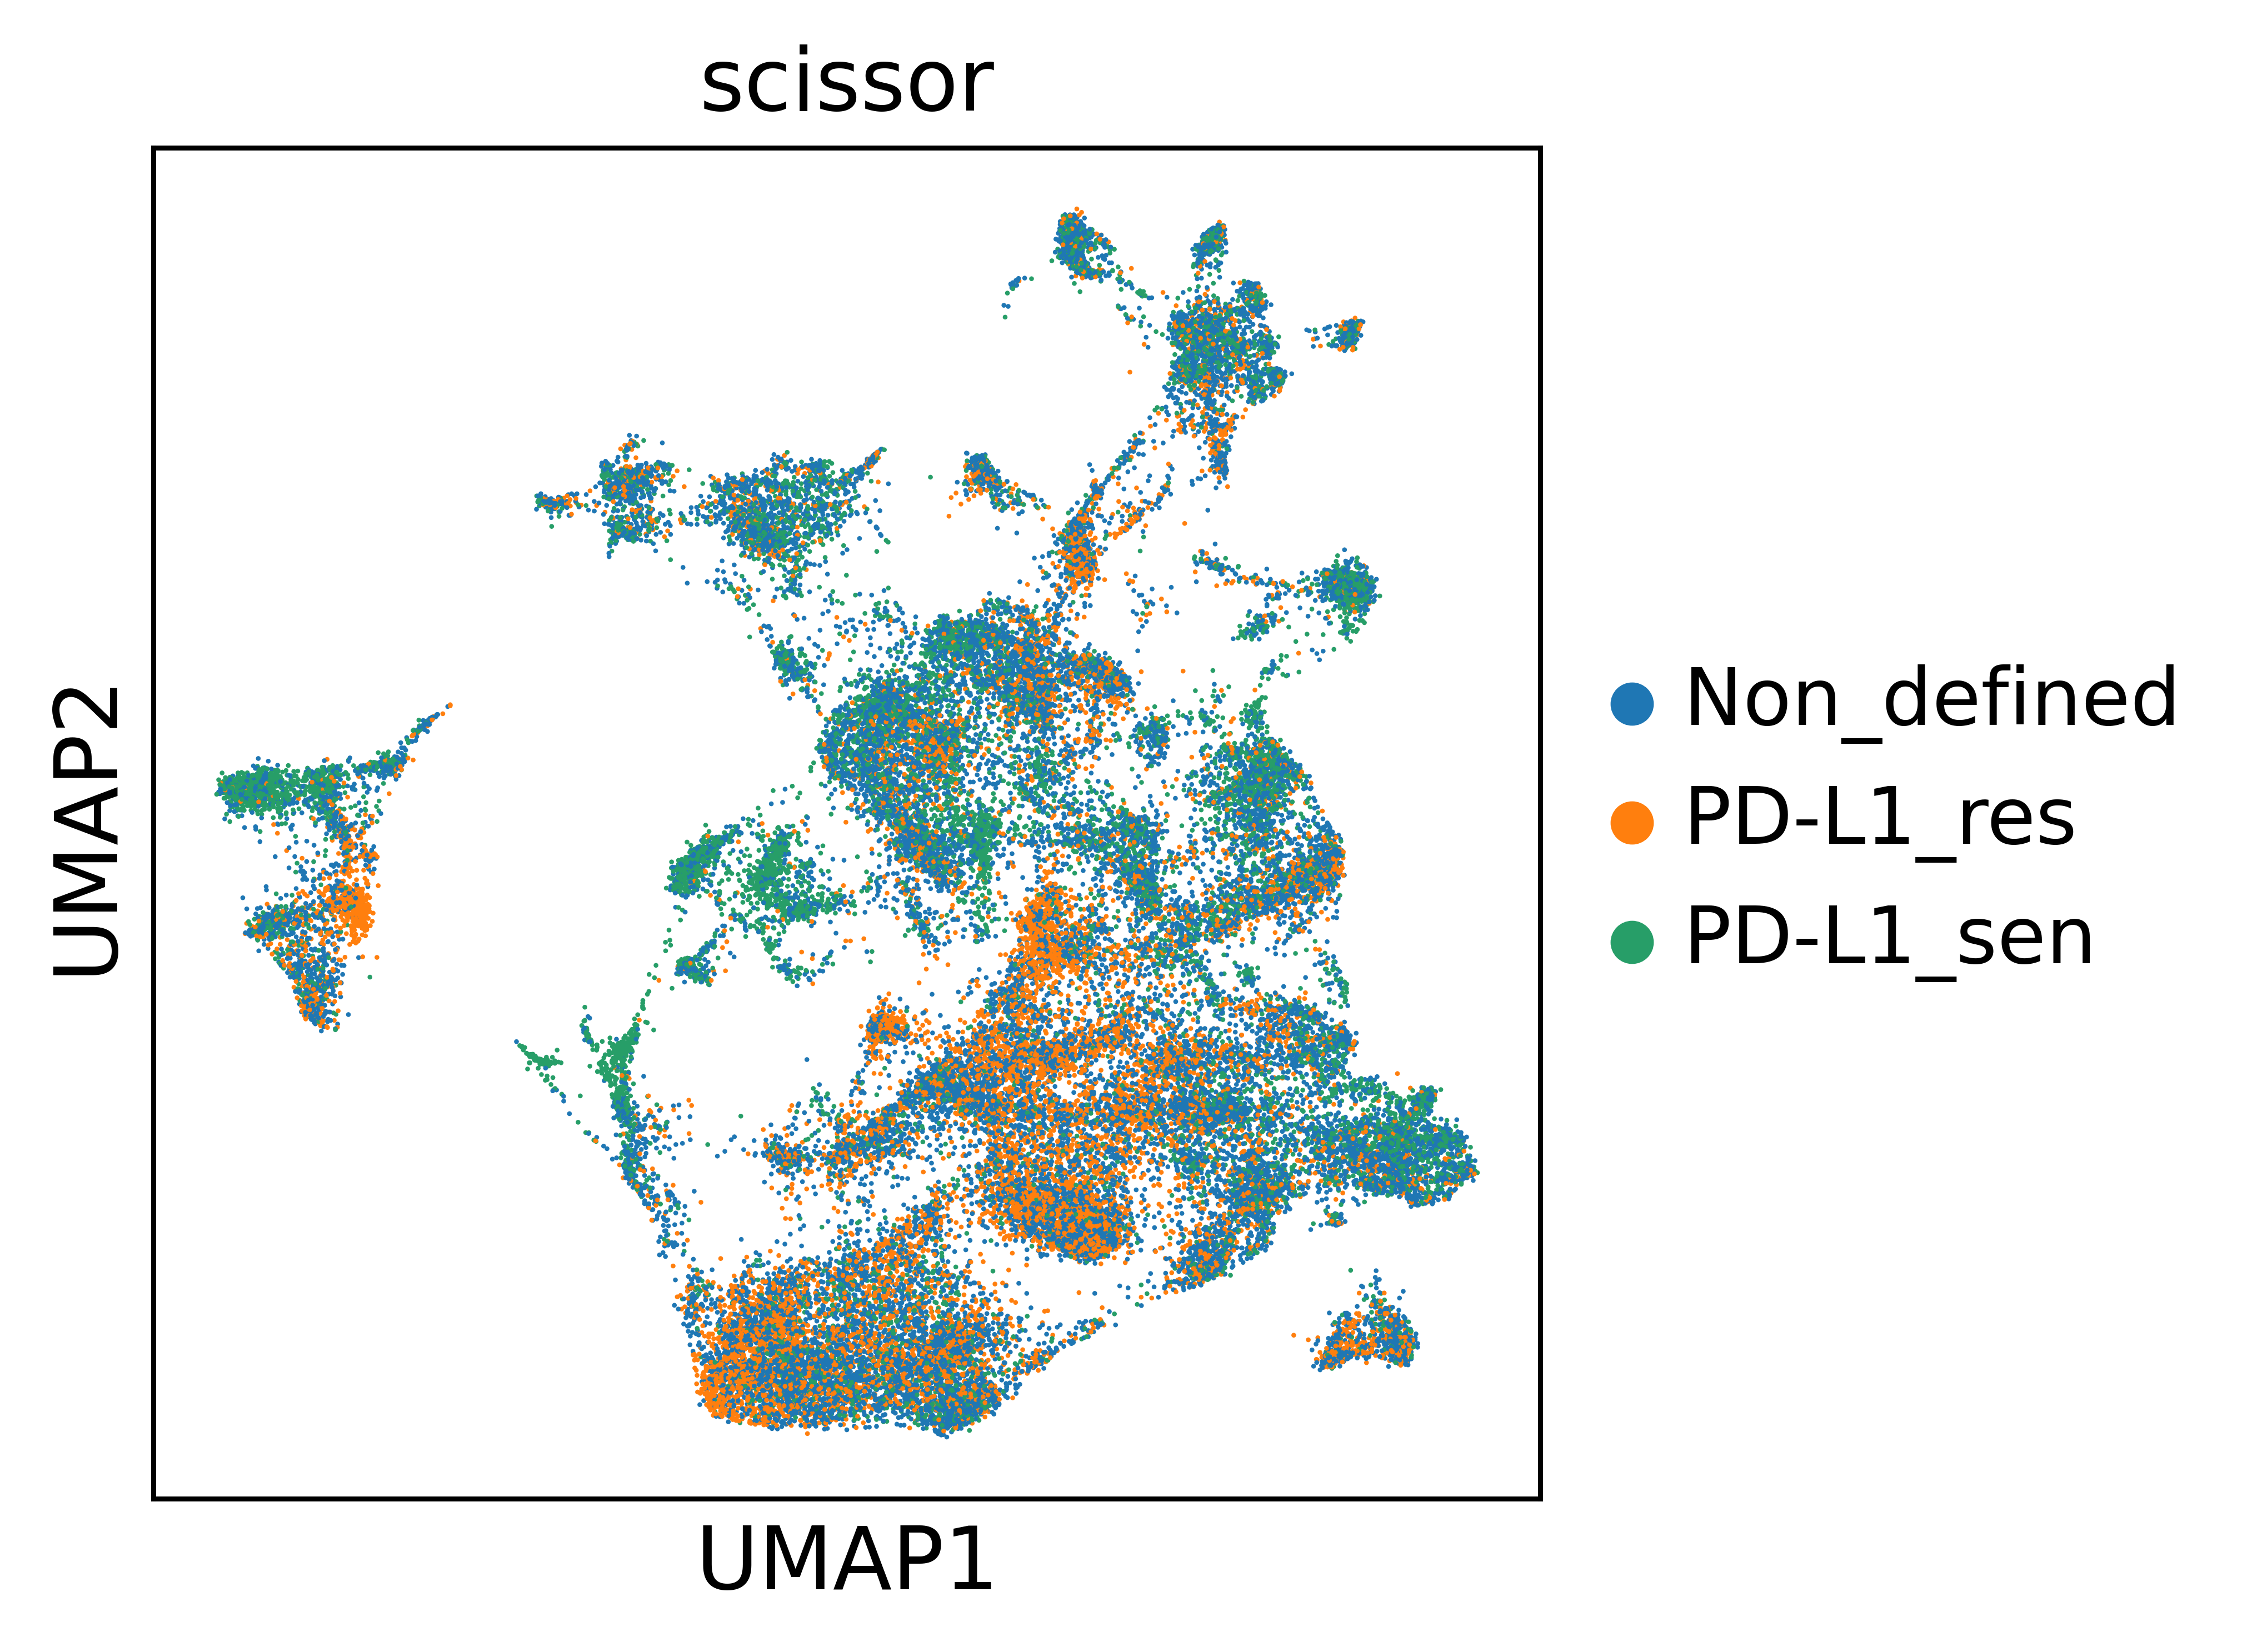

In [8]:
sc.pl.umap(adata, color="scissor")

In [9]:
d2c.score(adata, use_raw=True)

In [11]:
adata.uns['drug2cell']

AnnData object with n_obs × n_vars = 49784 × 2395
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.8', 'seurat_clusters', 'celltype', 'patient', 'tiss', 'scissor', 'scissor_celltype', 'RNA_snn_res.0.2'
    var: 'genes', 'all_genes'
    obsm: 'X_pca', 'X_umap'

... storing 'genes' as categorical
... storing 'all_genes' as categorical


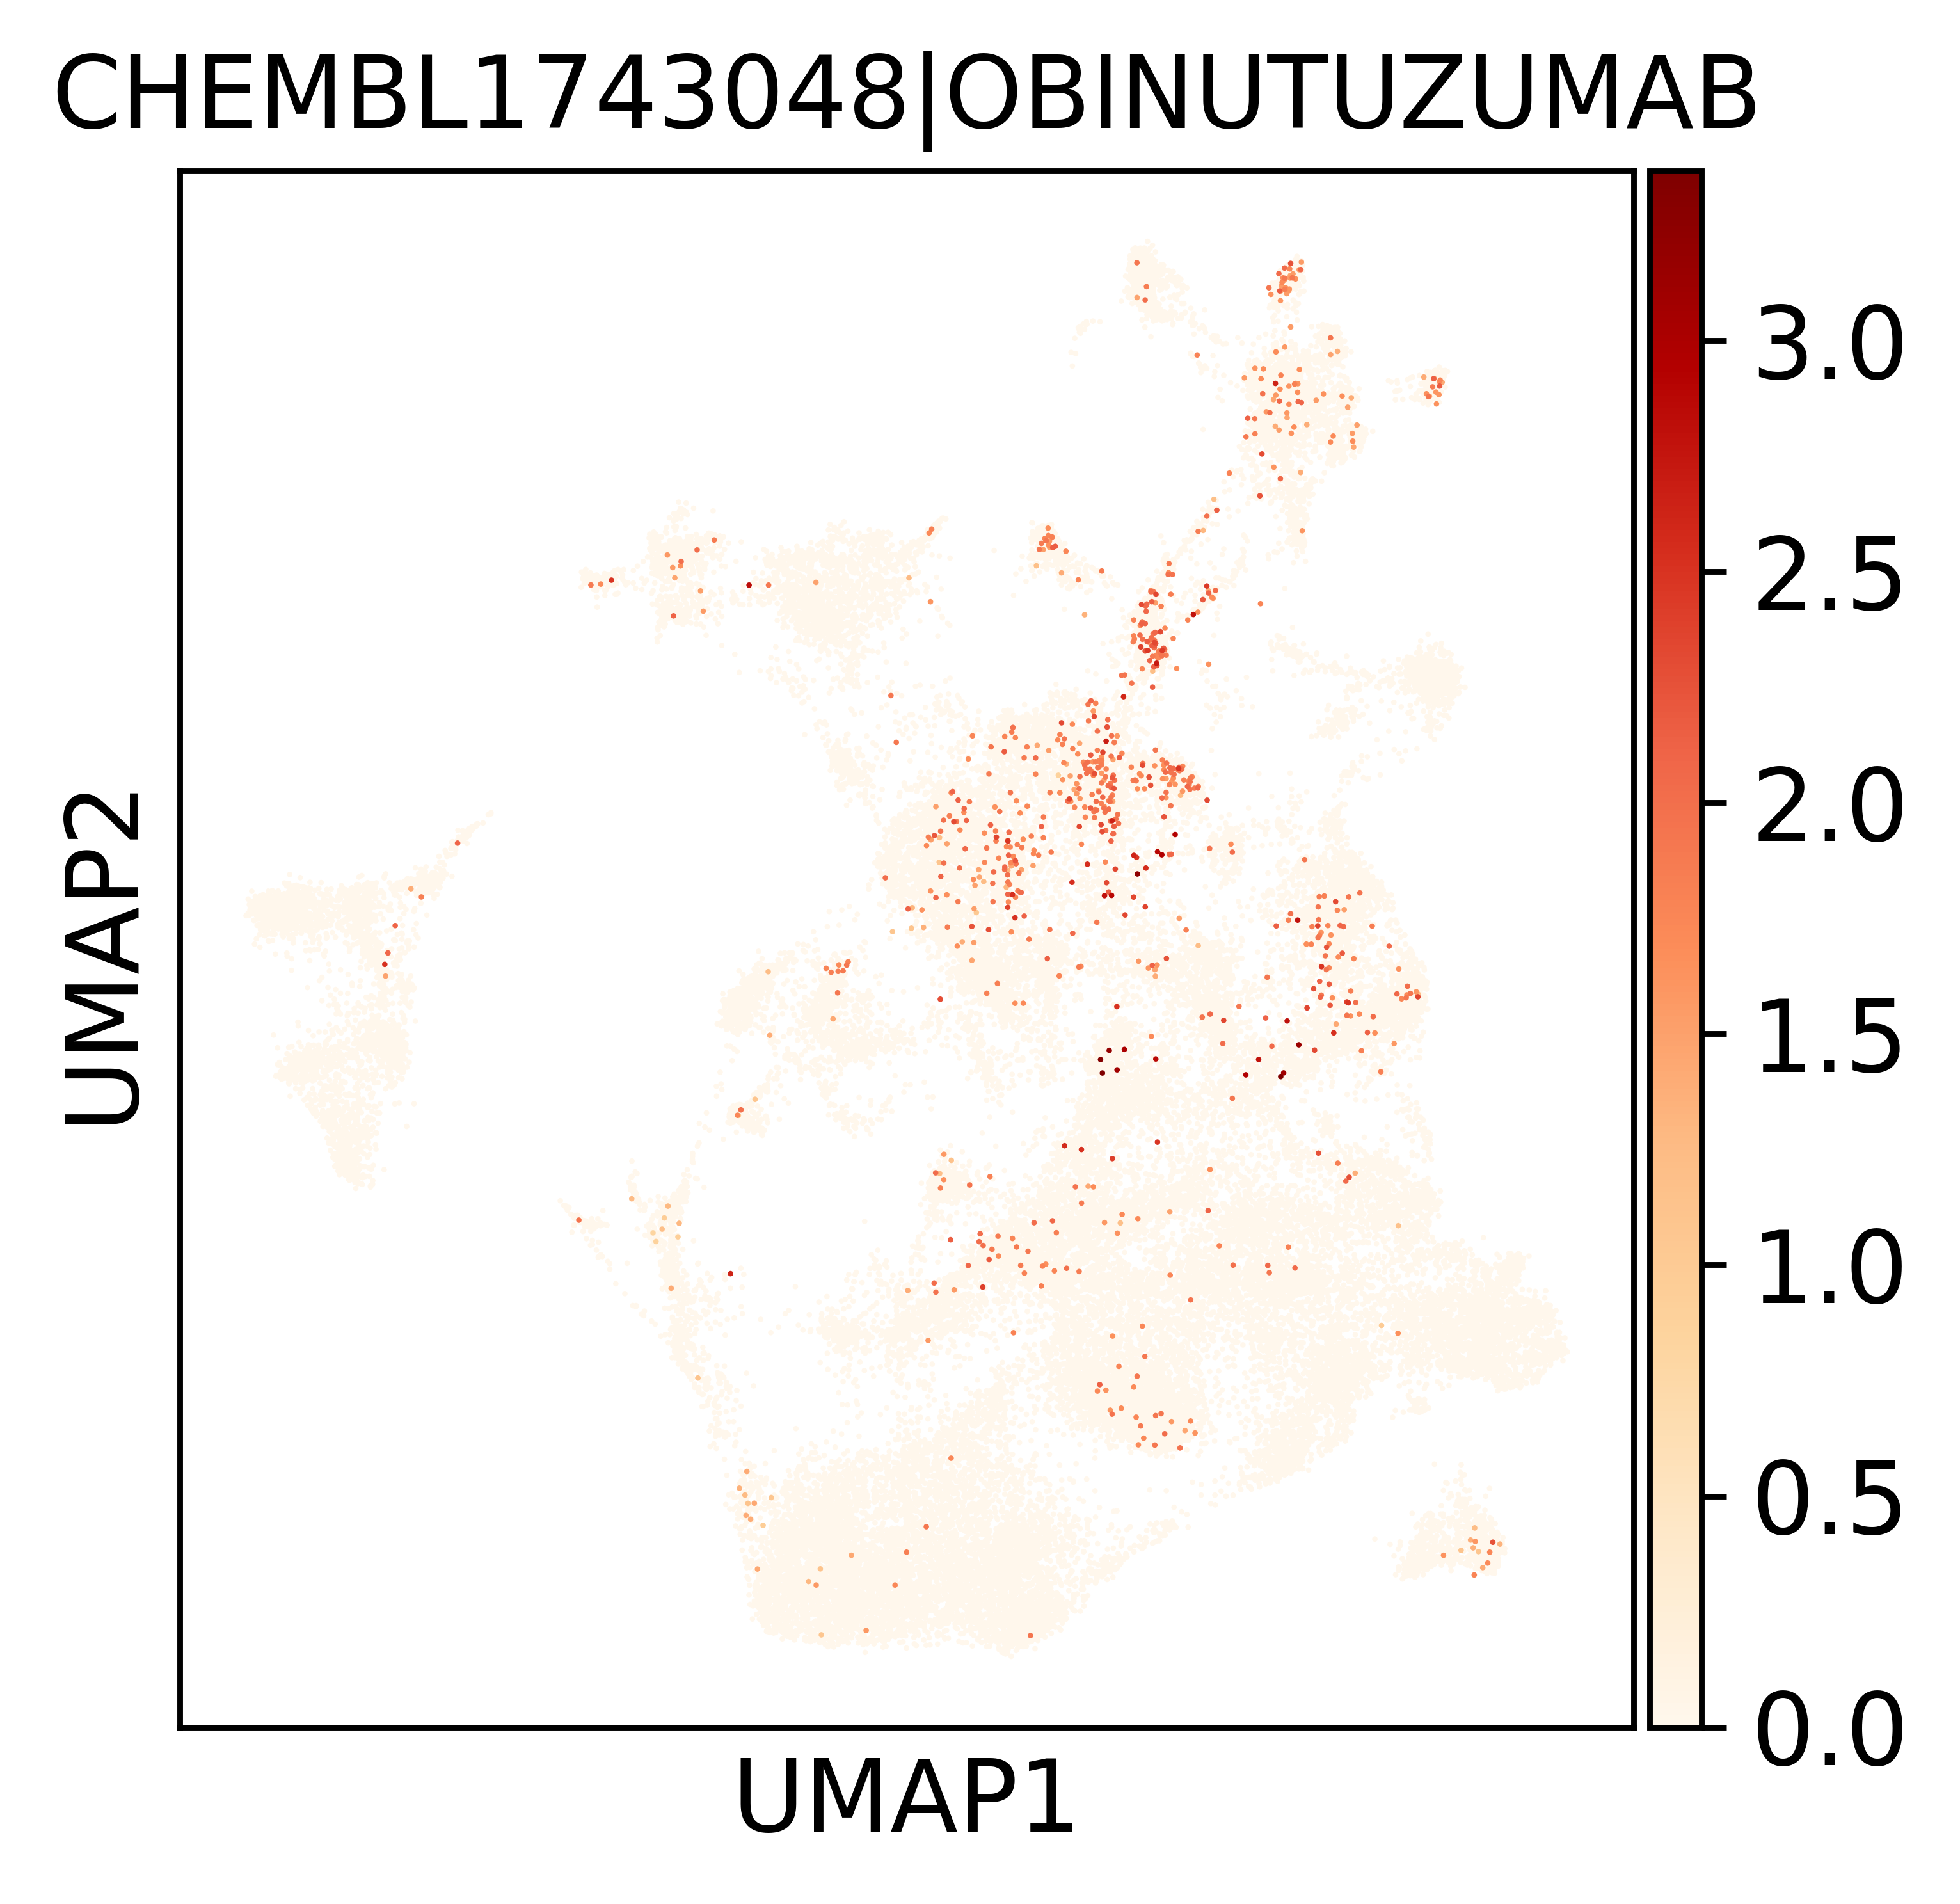

In [12]:
sc.pl.umap(adata.uns['drug2cell'], color="CHEMBL1743048|OBINUTUZUMAB", color_map="OrRd", save='drug2cell.png')

In [14]:
sc.tl.rank_genes_groups(adata.uns['drug2cell'], method="wilcoxon", groupby="scissor")

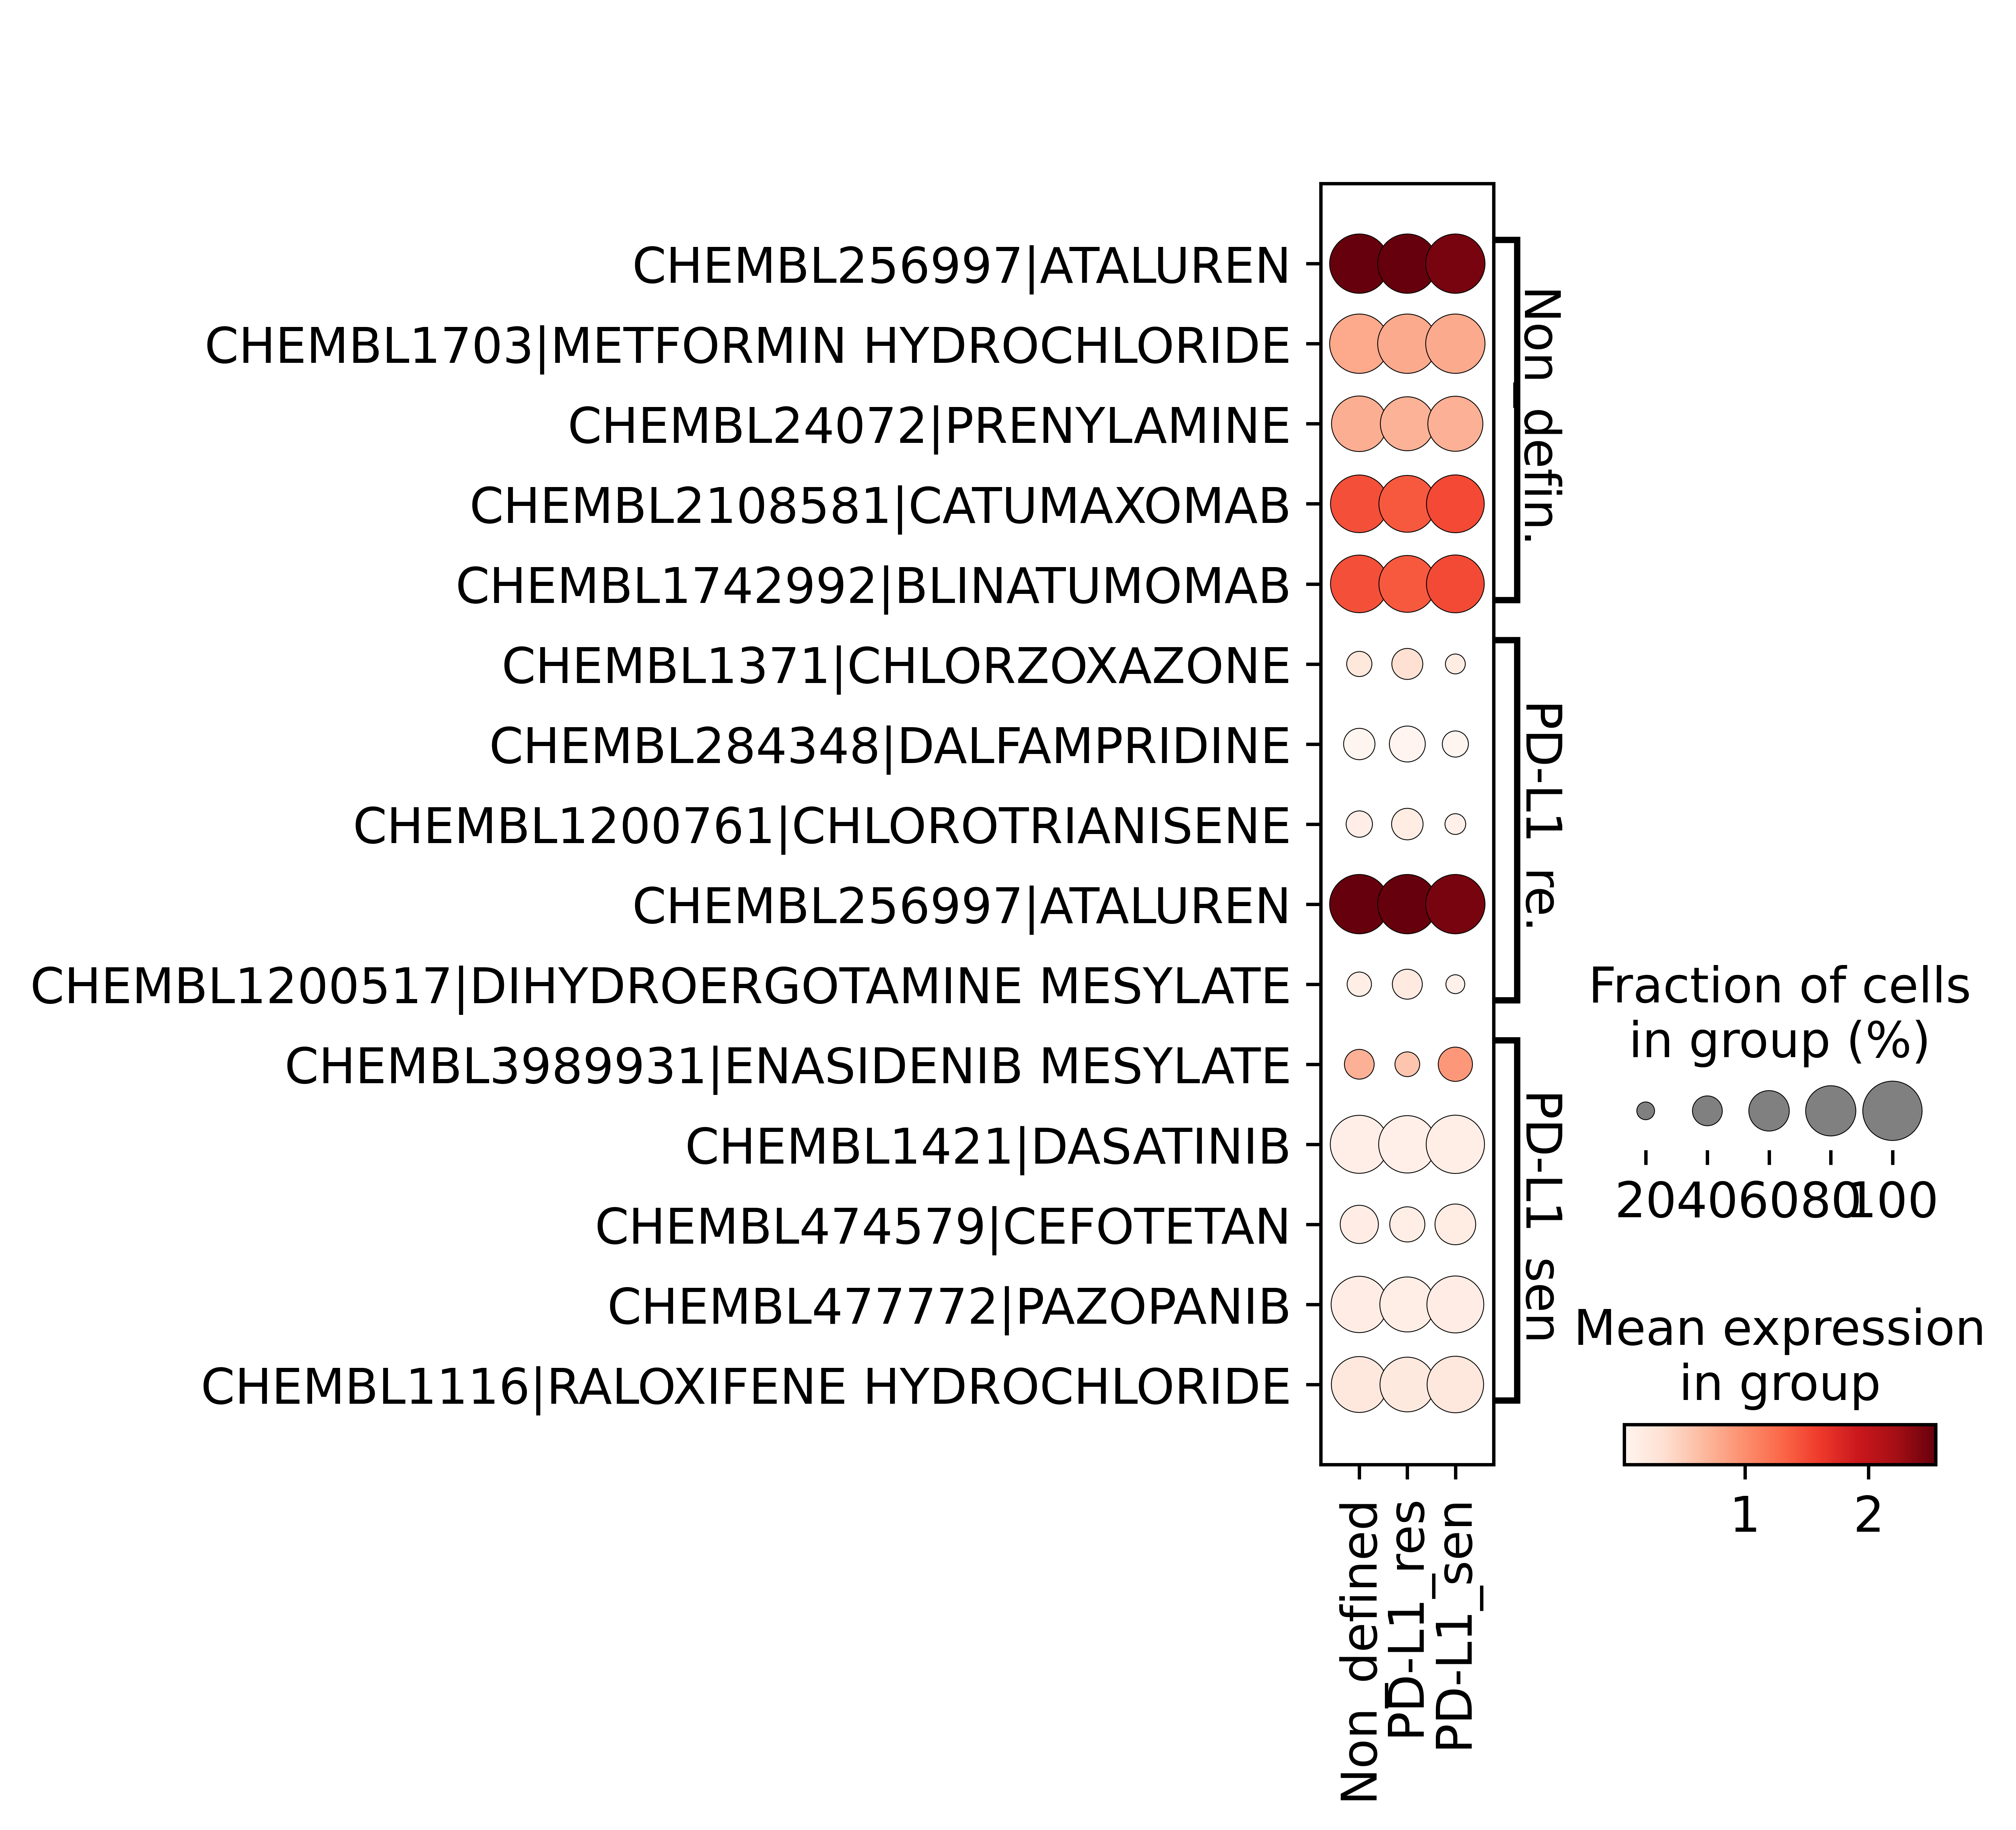

In [15]:
sc.pl.rank_genes_groups_dotplot(adata.uns['drug2cell'], swap_axes=True, dendrogram=False, n_genes=5, save='drug2cell_dotplat.png')

In [23]:
plot_args = d2c.util.prepare_plot_args(adata.uns['drug2cell'], categories=["B01","B02","B03"])
sc.pl.dotplot(adata.uns['drug2cell'], groupby="scissor", swap_axes=True, **plot_args,save='drug2cell_dotplat2.png')

{'var_names': ['CHEMBL799|CILOSTAZOL',
  'CHEMBL512351|BETRIXABAN',
  'CHEMBL522038|XIMELAGATRAN',
  'CHEMBL1466|DICUMAROL',
  'CHEMBL1166|ARGATROBAN',
  'CHEMBL334966|CANGRELOR',
  'CHEMBL1257015|PICOTAMIDE',
  'CHEMBL711|PHENINDIONE',
  'CHEMBL1201476|ENOXAPARIN SODIUM',
  'CHEMBL1201662|DESIRUDIN',
  'CHEMBL1464|WARFARIN',
  'CHEMBL493982|VORAPAXAR',
  'CHEMBL238804|SELEXIPAG',
  'CHEMBL25|ASPIRIN',
  'CHEMBL1201513|HEPARIN CALCIUM',
  'CHEMBL1771|CLOPIDOGREL',
  'CHEMBL833|TICLOPIDINE',
  'CHEMBL2108222|ALOXIPRIN',
  'CHEMBL1201505|FIBRINOLYSIN, HUMAN',
  'CHEMBL231779|APIXABAN',
  'CHEMBL1237119|TREPROSTINIL',
  'CHEMBL916|TIROFIBAN',
  'CHEMBL198362|RIVAROXABAN',
  'CHEMBL2109624|CAPLACIZUMAB',
  'CHEMBL1201657|HEPARIN SODIUM',
  'CHEMBL1174|EPTIFIBATIDE',
  'CHEMBL494|ILOPROST',
  'CHEMBL398435|TICAGRELOR',
  'CHEMBL1201414|TINZAPARIN SODIUM',
  'CHEMBL932|DIPYRIDAMOLE',
  'CHEMBL1201584|ABCIXIMAB',
  'CHEMBL2109065|DROTRECOGIN ALFA (ACTIVATED)',
  'CHEMBL1201460|DALTEPARIN SODI

In [27]:
adata.uns['drug2cell'].uns['rank_genes_groups']

{'params': {'groupby': 'scissor',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('CHEMBL256997|ATALUREN', 'CHEMBL1371|CHLORZOXAZONE', 'CHEMBL3989931|ENASIDENIB MESYLATE'),
            ('CHEMBL1703|METFORMIN HYDROCHLORIDE', 'CHEMBL284348|DALFAMPRIDINE', 'CHEMBL1421|DASATINIB'),
            ('CHEMBL24072|PRENYLAMINE', 'CHEMBL1200761|CHLOROTRIANISENE', 'CHEMBL474579|CEFOTETAN'),
            ...,
            ('CHEMBL61|PODOFILOX', 'CHEMBL2108581|CATUMAXOMAB', 'CHEMBL1743043|MOXETUMOMAB PASUDOTOX'),
            ('CHEMBL685|MEBENDAZOLE', 'CHEMBL1421|DASATINIB', 'CHEMBL4297573|TAGRAXOFUSP'),
            ('CHEMBL1433|DOXYCYCLINE ANHYDROUS', 'CHEMBL3989931|ENASIDENIB MESYLATE', 'CHEMBL256997|ATALUREN')],
           dtype=[('Non_defined', 'O'), ('PD-L1_res', 'O'), ('PD-L1_sen', 'O')]),
 'scores': rec.array([( 7.572935 ,  24.555616,  21.806662),
            ( 6.722878 ,  24.007494,  15.935015),
     

In [28]:
def save_rank_genes_combined(rank_data, output_file="rank_genes_combined.csv"):
    """将所有组的结果合并保存为一个文件"""
    import pandas as pd
    
    groups = rank_data['names'].dtype.names
    
    all_data = []
    
    for group in groups:
        print(f"处理组: {group}")
        
        # 提取数据
        group_df = pd.DataFrame({
            'group': group,
            'gene': rank_data['names'][group],
            'score': rank_data['scores'][group],
            'log2fc': rank_data['logfoldchanges'][group],
            'pval': rank_data['pvals'][group],
            'pval_adj': rank_data['pvals_adj'][group]
        })
        
        # 添加组内排名
        group_df = group_df.sort_values('score', ascending=False)
        group_df['rank_in_group'] = range(1, len(group_df) + 1)
        
        all_data.append(group_df)
    
    # 合并所有组
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # 按组和分数排序
    combined_df = combined_df.sort_values(['group', 'score'], ascending=[True, False])
    
    # 保存
    combined_df.to_csv(output_file, index=False, float_format='%.6f')
    
    print(f"\n已合并保存 {len(combined_df)} 行数据到: {output_file}")
    print(f"包含组: {groups}")
    
    return combined_df


In [29]:
combined_df = save_rank_genes_combined(
    adata.uns['drug2cell'].uns['rank_genes_groups'],
    output_file="drug_rank_genes_combined.csv"
)

处理组: Non_defined
处理组: PD-L1_res
处理组: PD-L1_sen

已合并保存 7185 行数据到: drug_rank_genes_combined.csv
包含组: ('Non_defined', 'PD-L1_res', 'PD-L1_sen')


In [30]:
df = pd.read_csv('filter.csv')

In [48]:
gene_list = df['gene'].tolist()

# 只取前N个基因，避免图表太拥挤
top_genes = gene_list[:20]  # 取前20个

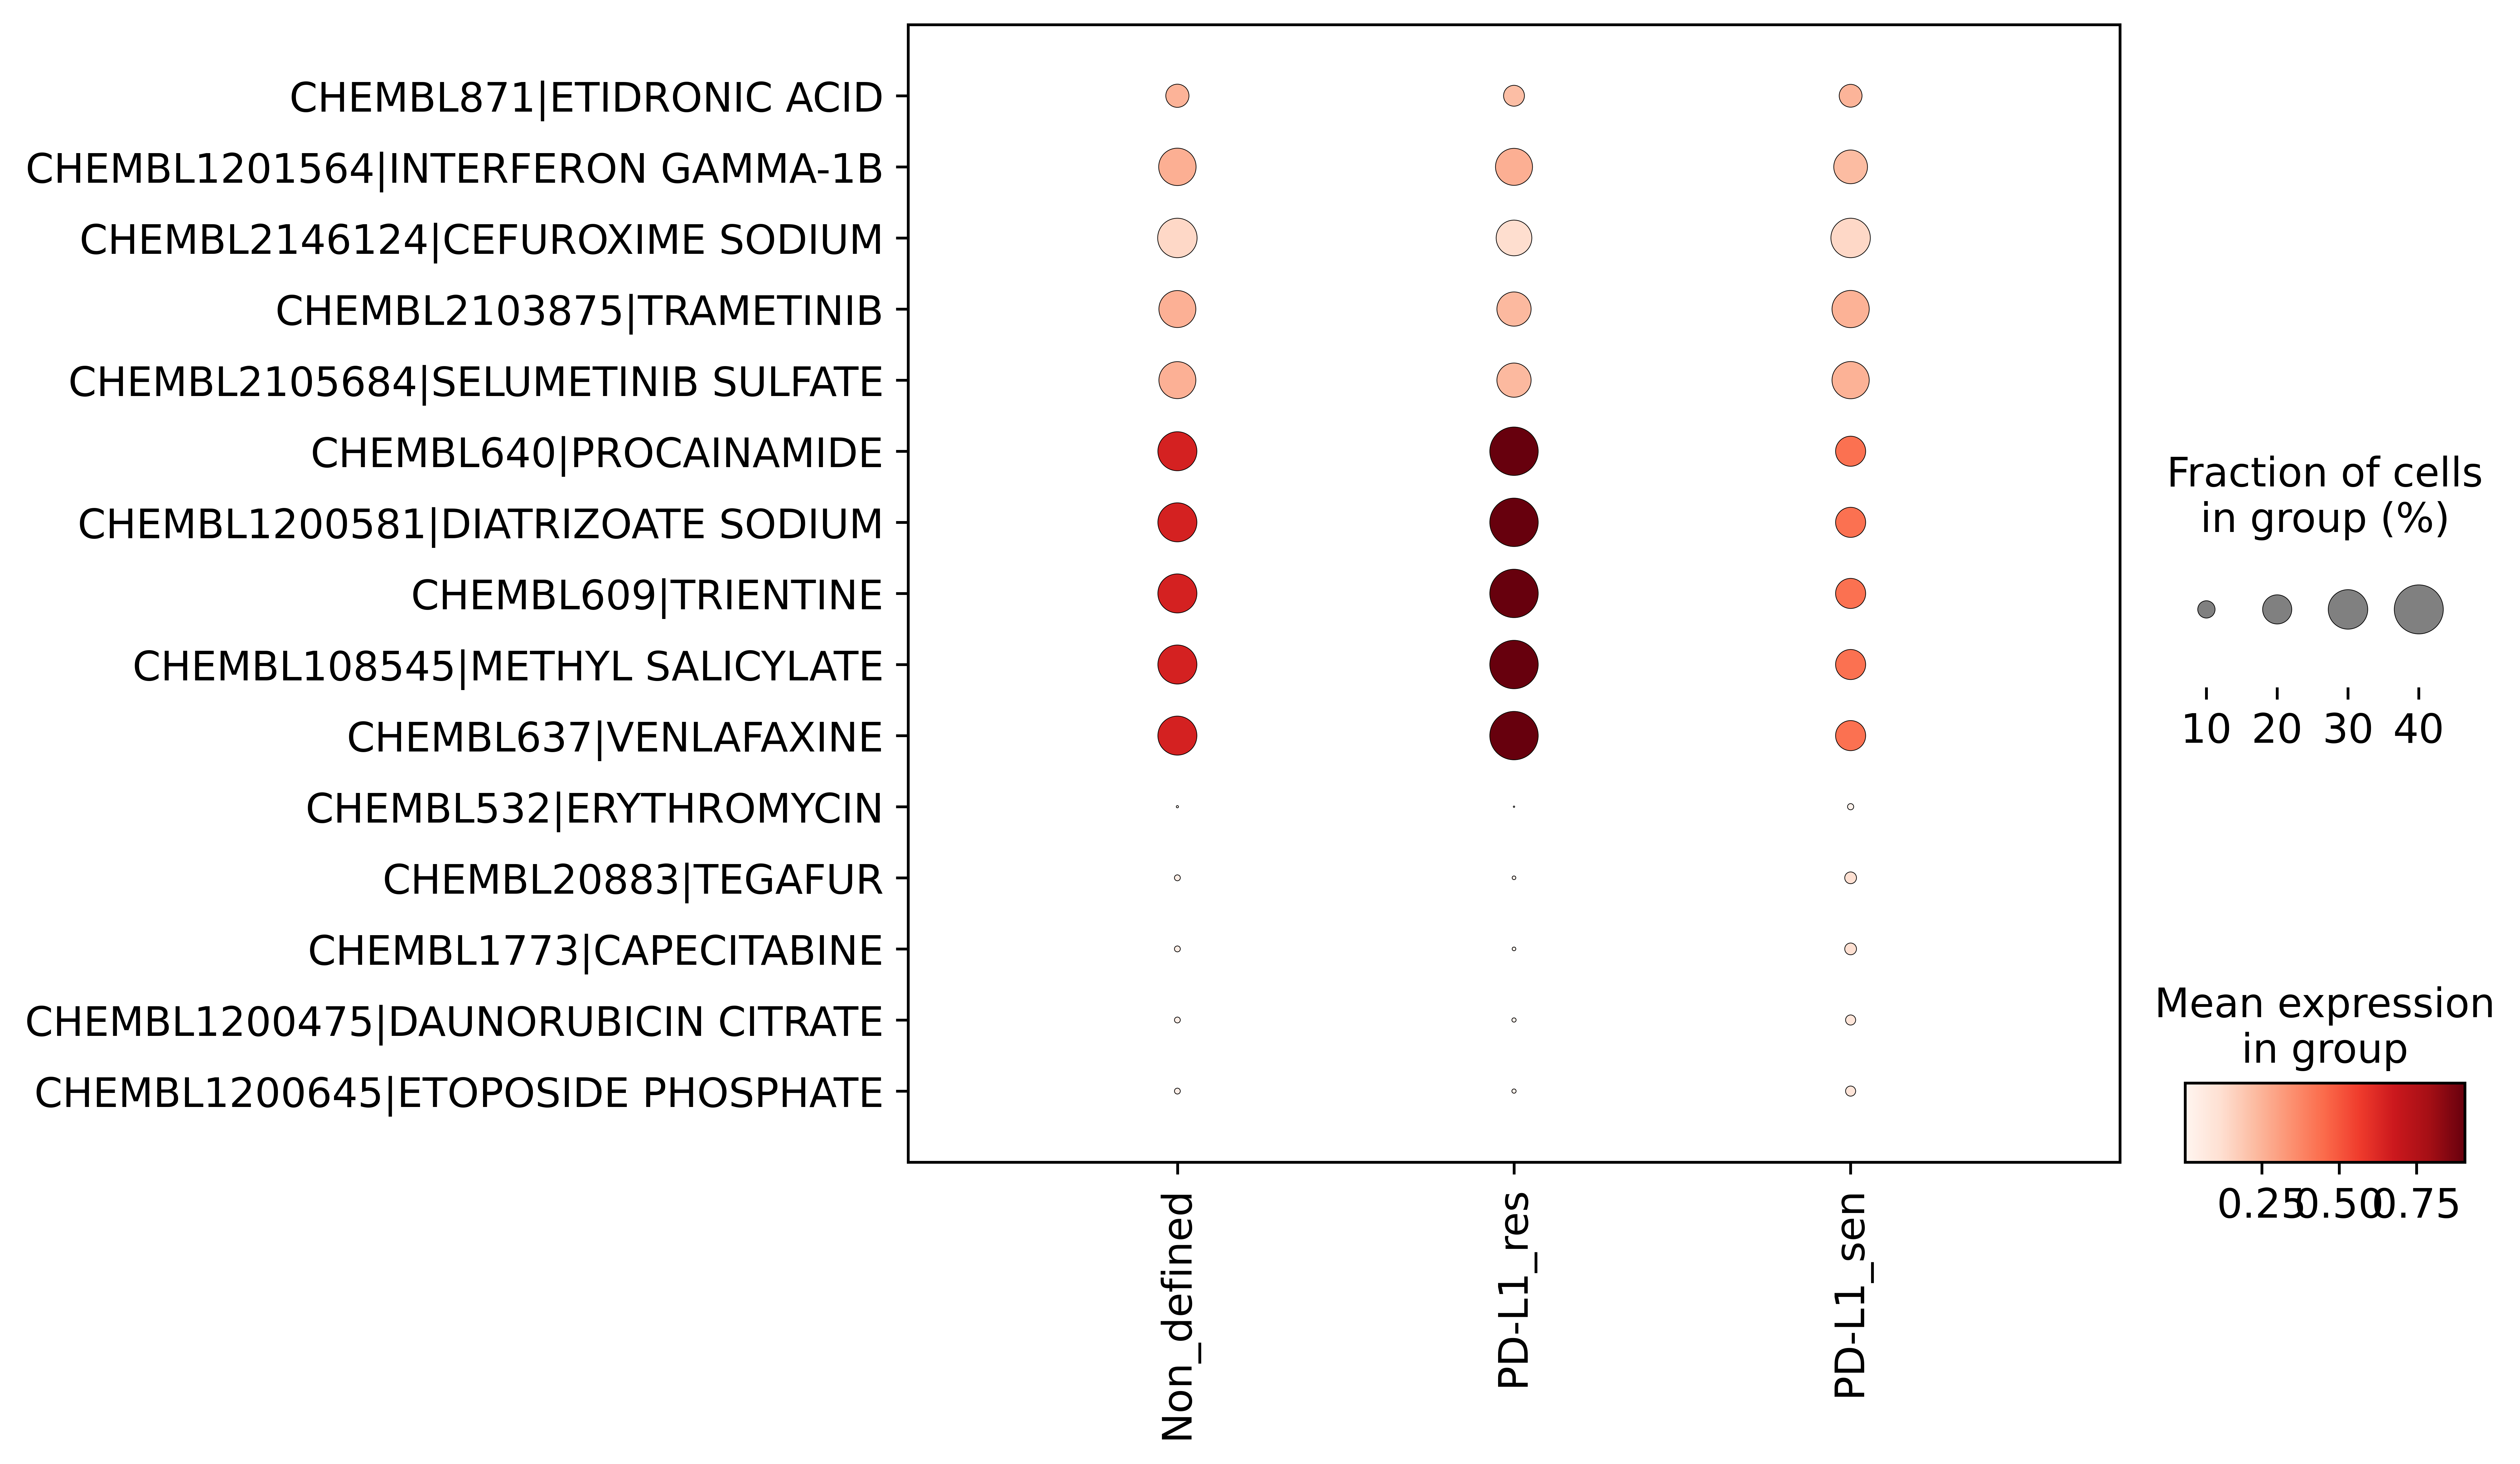

In [59]:
sc.pl.dotplot(adata.uns['drug2cell'], groupby="scissor", swap_axes=True, var_names=top_genes,figsize=(8, 6),
             save='drug2cell_dotplat3.pdf')